# RAIL - Fundamentals

<img align="left" src = https://linea.org.br/wp-content/themes/LIneA/imagens/logo-header.jpg width=100 style="padding: 20px"> 


<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=160 style="padding: 20px">  

# Photo-z Server - Tutorial Notebook

**Contact author**: Julia Gschwend ([julia@linea.org.br](mailto:julia@linea.org.br)) 

**Last verified run**: 2022-11-07 <br>


RAIL is a LSST-DESC software created to process different algorithms used to calculate photometric redshift. Its main goal is to minimize impact that different infrastructures can cause on different algorithms, for that it unifyes in a modular code supporting different inputs that different algorithms needs and padronizing the output so that it can be a more fair comparison between their results.

Rail uses 4 principal libraries in its core: <br>
_tables_io_: for data manipulation as hdf5 files, fits, etc. <br>
_qp_: used to paremitrize data PDFs for metrics calculation. <br>
_ceci_: construct pipelines, produces a .yaml within the steps and configurations as threads. <br>
_pzflow_: creates a flow for data creation. <br>

#### Core.
Where the main functions are going to manage the data and files that the program creates. It works almost like the behavioral chain of resposability pattern (https://refactoring.guru/pt-br/design-patterns/chain-of-responsibility), where you create a flux in the code, where there is a request related/processed by a class handler that decides to pass it foward or not according to what is defined. So for that, what bpz does is create a class request (eg: Inform_BPZ_lite) that has all the inputs/configurations and is handled by its class handler (BPZ_lite).

#### Creation.
Contain all the support for data creation, as degradors, data flow creation, Column remapping, etc. It creates .hdf5 files with the data that is being manipulated.

#### Estimation.
This is where the codes are defined and executed.  <br>
inform: this is where the PRIORS for template fitting are informed and the machine learning codes are trained. <br>
estimate: where the algorith is executed though the .evaluate() function.
The code is wrapped as a RAIL stage so that it can be run in a controlled way. Estimation code can be stored in a yaml file to be run as a ceci module.


#### Evaluation.
This step contais the metrics for performance of the estimated codes.
<br>
------
For installation instructions check the official documentation: https://lsstdescrail.readthedocs.io/en/latest/source/installation.html <br>

Its important to point out that as Rail is still being developed it may be necessary to do a update (once in a while) to you rail installed packages. <br> 
If its intalled via github then first you must update the cloned rail repository: _git pull origin_ <br>
Then, run: `pip install pz-rail-bpz --upgrade`
`pip install pz-rail --upgrade`

If its installed via pip then only the upgrade is necessary.

For Rail versions and documentation check: https://github.com/LSSTDESC/RAIL/releases

 ipykernel with conda install ipykernel
 python -m ipykernel install –user –name [nametocallnewkernel] 

## Imports, setup and some sample data

In [1]:
import os
import numpy as np
import pandas as pd
import qp
import tables_io
import matplotlib.pyplot as plt

import rail
from rail.core.utils import RAILDIR
from rail.core.data import TableHandle, PqHandle, ModelHandle, QPHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

from rail.estimation.algos.bpz_lite import Inform_BPZ_lite, BPZ_lite
from rail.evaluation.evaluator import Evaluator

from rail.estimation.algos.knnpz import Inform_KNearNeighPDF

In [2]:
CURR_DIR = os.getcwd()
CURR_DIR, RAILDIR

('/home/heloisamengisztki/WORK/ic-photoz/Fase2-RAIL/rail-fundamentals',
 '/home/heloisamengisztki/.local/lib/python3.10/site-packages')

### Reading some sample

In [3]:
data_columns = ["coadd_objects_id","ra","dec","mag_g","magerr_g","mag_i","magerr_i","mag_r","magerr_r","mag_u","magerr_u","mag_y","magerr_y","mag_z","magerr_z","z_true"]

file_path = '/home/heloisamengisztki/DATA/dp0_train_random.csv'
full_data = pd.read_csv(file_path, usecols=data_columns)
full_data.head()

,coadd_objects_id,z_true,ra,dec,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y
0,18599476134425521,2.842380,60.4467,-34.0560,26.1816,25.7714,25.6290,25.9107,25.6477,NaN,0.3817,0.0941,0.1011,0.2273,0.5400,-0.7377
1,13542134963533657,2.888735,59.2224,-43.1165,26.4664,27.0861,27.1896,28.7258,24.9601,26.0376,0.5607,0.3413,0.3672,3.1551,0.2299,1.3945
2,18617081205359130,1.290350,67.6464,-33.5759,26.7561,27.2174,26.8622,25.6075,25.2444,24.4690,0.5764,0.3407,0.2659,0.1358,0.2957,0.3227
3,17724148914627425,2.442620,65.1607,-34.4085,26.7917,26.0648,25.7113,26.3745,NaN,26.2090,0.7288,0.1233,0.1153,0.3547,NaN,1.7678
4,14373666401847353,1.463598,73.0255,-40.2059,23.7023,23.5788,23.6343,23.4418,23.3789,22.8774,0.0423,0.0139,0.0144,0.0246,0.0525,0.0651


#### Spliting into train and test data

In [4]:
size = len(full_data)//2

train_sample = full_data.sample(n=size,ignore_index=True)
test_sample = full_data.drop(train_sample.index)

In [5]:
train_sample.head()

,coadd_objects_id,z_true,ra,dec,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y
0,17716027131470567,0.551877,60.2358,-35.1148,25.0702,25.5462,25.0705,24.6702,24.1798,23.8673,0.1392,0.0699,0.0584,0.0673,0.1492,0.1731
1,14368710009579209,1.050643,72.2014,-40.7827,NaN,26.5723,26.6380,26.0706,25.8855,NaN,NaN,0.1470,0.1887,0.1978,0.4264,-19.2522
2,21335477676159992,2.597062,56.8487,-29.4104,27.0969,26.0461,25.9731,26.8355,26.1577,24.9263,0.9958,0.1216,0.1219,0.5306,0.7492,0.4920
3,18626027622267088,0.996290,70.7486,-32.8375,26.3635,25.9679,26.0404,25.5409,26.6184,24.8711,0.3529,0.0824,0.1061,0.1206,0.8600,0.3501
4,15151704022495029,1.685075,57.0515,-38.8950,26.7042,25.9116,26.2063,25.9087,26.1263,27.9162,0.6256,0.0985,0.1619,0.2252,0.7806,6.9637


In [6]:
test_sample.head()

,coadd_objects_id,z_true,ra,dec,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y
40406,14320460346985530,1.083167,50.4691,-41.1147,26.5377,26.7127,26.0790,26.0657,25.5970,25.3729,0.5290,0.2024,0.1510,0.2448,0.4600,0.6812
40407,19505632629520281,1.228961,62.7543,-31.6018,26.9483,26.6153,26.6607,25.9465,24.8356,24.4789,0.5684,0.1813,0.1866,0.1587,0.1882,0.2849
40408,14355786452989168,1.005510,65.7566,-40.9686,25.4074,26.4859,25.8216,25.7213,25.3755,24.4304,0.2320,0.1810,0.1192,0.2347,0.4900,0.3558
40409,13568411573424664,1.727726,71.6283,-41.7451,26.5434,25.7170,25.7152,25.4834,25.6776,25.0296,0.3836,0.0772,0.0948,0.1318,0.4083,0.4969
40410,16840279004839546,0.995374,59.1503,-36.0538,27.0809,26.0884,25.5183,25.5132,24.7519,24.8049,0.9508,0.1255,0.0814,0.1516,0.2752,0.4863


---

##  RAIL 

Rail has a lot of classes and it uses Object Oriented Programming - POO, therefore things can get complicated very fast, but for now we are going to focus on understanging a little bit of the three bases ones: **RailStage, DataStore and DataHandler**

**Image:** This diagram represents some classes and its hierarchy.

![title](RAILclasses.png)


## DataStore

The data store class is the class that is going to store all the data that is being processed associated with a key value. For example for a file containing the sample that we are going to use to test an algorithm named 'test_sampe.hdf5' we add this to the data store naming the key 'test_sample' and a what class (DaataHandler) is it going to use to read it, in this case TableHandler -> HandlerHdf5. 
<br>

Another important thing to know is that the DataStore class acts as a [singleton class](https://refactoring.guru/design-patterns/singleton) wich basically is a class that has only one instance in the aplication. That is important due to the fact that rail keeps all the data and handlers as it runs so that the previous stage can access and read it. Based on that when if we try to create another instace, what its going to do is serve as a DataStore factory, but not the DataStore class itself.  
<br>

We can see access the data storage trough the attribute data_store. By default it does not allow to overwrite the data tha its being stored so if we want to change the value of a key we have to manually set the property allow_overwrite to true.

In [7]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True
DS

DataStore
{}

To help us undestand better we are constantly going to monitor how DataStore stores the data and how the memory goes with that.

In [8]:
import sys

sys.getsizeof(DS), 'bytes'

(80, 'bytes')

We can manually add data to the data store with the add_data or pass a file and store it in the DS with the read_file.

In [9]:
DS.add_data(key="input", data=train_sample, handle_class=PqHandle)
## DS.read_file(key="name", path=file_path, handle_class=Handler)
DS

DataStore
{  input:<class 'rail.core.data.PqHandle'> None, (d)
}

Here is how we can access the data, what it is going to do is use the handler that we passed

In [10]:
sys.getsizeof(DS), 'bytes'

(248, 'bytes')

In [11]:
DS.read("input").head()

,coadd_objects_id,z_true,ra,dec,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y
0,17716027131470567,0.551877,60.2358,-35.1148,25.0702,25.5462,25.0705,24.6702,24.1798,23.8673,0.1392,0.0699,0.0584,0.0673,0.1492,0.1731
1,14368710009579209,1.050643,72.2014,-40.7827,NaN,26.5723,26.6380,26.0706,25.8855,NaN,NaN,0.1470,0.1887,0.1978,0.4264,-19.2522
2,21335477676159992,2.597062,56.8487,-29.4104,27.0969,26.0461,25.9731,26.8355,26.1577,24.9263,0.9958,0.1216,0.1219,0.5306,0.7492,0.4920
3,18626027622267088,0.996290,70.7486,-32.8375,26.3635,25.9679,26.0404,25.5409,26.6184,24.8711,0.3529,0.0824,0.1061,0.1206,0.8600,0.3501
4,15151704022495029,1.685075,57.0515,-38.8950,26.7042,25.9116,26.2063,25.9087,26.1263,27.9162,0.6256,0.0985,0.1619,0.2252,0.7806,6.9637


#### Memory x Files

As we can see, as soon that we added the data to the DS the memory increased in 200 bytes. In Rail we can store data as a tableLike object as pandas dataframe, orderDic, etc. but we can also work with the flow in memory. For that there are a bunch of steps/configs that are going differ from bringing or not the data to memory.

## DataHandler

As all the stages herd from RailStages, [Delegate Pattern](https://en.wikipedia.org/wiki/Delegation_pattern), that can be seen in figure of the classe maped above, and RailStages can be seen as a 
[CeciStage](https://github.com/LSSTDESC/ceci/blob/d1d5686aefab18bc53e3d4d8a05af42d19e28a91/ceci/stage.py#L24]), when we declare a stage we use the method _make_stage(**args)_, what id does is to return the object itself as a stage configured with the given parameters. 

To undestand how the returned object works we can use an explanation present in the c# language for [delegate](https://docs.microsoft.com/pt-br/dotnet/csharp/programming-guide/delegates/using-delegates). Basically we can think of delegates as a method that points to an abstract class and a method of that class that is going to execute. Therefore a class that behaves as a method and can be executed. In python this method can be declared as `__call__` and the retuned class can be executed as class(), then this is going to execute the defined methos class. For RailStages it is going to run the algorithm.

**Image:** basic flux of inputs and outputs. 

![title](SimpleRailBPZflow.png)


## PRIOR - Preparing Data
Here we are going to start preparing our data, first we set the ColumnMapper stage that is going to remmap all the data columns for bpz algorithm

In [12]:
##help(ColumnMapper)

In [13]:
columns_map = {
"coadd_objects_id": "id",
"ra": "coord_ra",
"dec": "coord_dec",
"mag_g": "mag_g_lsst",
"magerr_g": "mag_err_g_lsst",
"mag_r": "mag_r_lsst",
"magerr_r": "mag_err_r_lsst",
"mag_i": "mag_i_lsst",
"magerr_i": "mag_err_i_lsst",
"mag_u": "mag_u_lsst",
"magerr_u": "mag_err_u_lsst",
"mag_y": "mag_y_lsst",
"magerr_y": "mag_err_y_lsst",
"mag_z": "mag_z_lsst",
"magerr_z": "mag_err_z_lsst",
"z_true": "redshift"
}

col_remapper = ColumnMapper.make_stage(name='col_remapper', columns=columns_map)
print(f"Returned class: {type(col_remapper)}")

Returned class: <class 'rail.core.utilStages.ColumnMapper'>


In [14]:
sys.getsizeof(DS), 'bytes'

(248, 'bytes')

we can see the configurations of the returned class with `returned_obj.config.to_dict()`

In [15]:
##col_remapper.config.to_dict()

Basically we can call execute it these ways using the notebook.
1. When the data is added manually to the DS with `col_remapper.run()`
2. Passing the data trough parameter and invoking the method as `col_remapper(dataAsTableLike)`

in this case we are going to call the method run

In [16]:
## remembering what data we are storing
DS.read("input").head()

,coadd_objects_id,z_true,ra,dec,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y
0,17716027131470567,0.551877,60.2358,-35.1148,25.0702,25.5462,25.0705,24.6702,24.1798,23.8673,0.1392,0.0699,0.0584,0.0673,0.1492,0.1731
1,14368710009579209,1.050643,72.2014,-40.7827,NaN,26.5723,26.6380,26.0706,25.8855,NaN,NaN,0.1470,0.1887,0.1978,0.4264,-19.2522
2,21335477676159992,2.597062,56.8487,-29.4104,27.0969,26.0461,25.9731,26.8355,26.1577,24.9263,0.9958,0.1216,0.1219,0.5306,0.7492,0.4920
3,18626027622267088,0.996290,70.7486,-32.8375,26.3635,25.9679,26.0404,25.5409,26.6184,24.8711,0.3529,0.0824,0.1061,0.1206,0.8600,0.3501
4,15151704022495029,1.685075,57.0515,-38.8950,26.7042,25.9116,26.2063,25.9087,26.1263,27.9162,0.6256,0.0985,0.1619,0.2252,0.7806,6.9637


In [17]:
col_remapper.run()
print(f"\nRodando em paralelo -> {col_remapper.is_parallel()}")
DS

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper

Rodando em paralelo -> False


DataStore
{  input:<class 'rail.core.data.PqHandle'> None, (d)
  output_col_remapper:<class 'rail.core.data.PqHandle'> inprogress_output_col_remapper.pq, (d)
}

We can see that it is storing the outputs in the DS before the stage. Lets check the outupt

In [18]:
col_remapper.get_data("output").head() 
## or trough DS as 
##DS.read("output_col_remapper")
##DS["output_col_remapper"].data

#tables_io.convertObj(DS.read("output_estimate_bpz").build_tables()['ancil'], tables_io.types.PD_DATAFRAME)

,id,redshift,coord_ra,coord_dec,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,mag_err_u_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst
0,17716027131470567,0.551877,60.2358,-35.1148,25.0702,25.5462,25.0705,24.6702,24.1798,23.8673,0.1392,0.0699,0.0584,0.0673,0.1492,0.1731
1,14368710009579209,1.050643,72.2014,-40.7827,NaN,26.5723,26.6380,26.0706,25.8855,NaN,NaN,0.1470,0.1887,0.1978,0.4264,-19.2522
2,21335477676159992,2.597062,56.8487,-29.4104,27.0969,26.0461,25.9731,26.8355,26.1577,24.9263,0.9958,0.1216,0.1219,0.5306,0.7492,0.4920
3,18626027622267088,0.996290,70.7486,-32.8375,26.3635,25.9679,26.0404,25.5409,26.6184,24.8711,0.3529,0.0824,0.1061,0.1206,0.8600,0.3501
4,15151704022495029,1.685075,57.0515,-38.8950,26.7042,25.9116,26.2063,25.9087,26.1263,27.9162,0.6256,0.0985,0.1619,0.2252,0.7806,6.9637


In [19]:
sys.getsizeof(DS), 'bytes'

(248, 'bytes')

____
**OBSERVATION**

Passing the input in make_stage does not work
`ColumnMapper.make_stage(name='col_remapper_train_2', columns=columns_map, input='test')`

While a did the test of putting the input as name of DS PqHandler does not work, what it does when we call run what it does primary is to call get_data <br>
`data = self.get_data('input', allow_missing=True)` <br>
this search in the DS to a key named input.

To change that would be necessary to call the method <br>
`self.set_data(self.config.input, data)` <br> before and if not set then serach by the key 'input'
___

In [20]:
DS.add_data(key="input", data=col_remapper.get_data("output"), handle_class=PqHandle)
print(DS)
DS.read("input").head()

{  input:<class 'rail.core.data.PqHandle'> None, (d)
  output_col_remapper:<class 'rail.core.data.PqHandle'> inprogress_output_col_remapper.pq, (d)
}


,id,redshift,coord_ra,coord_dec,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,mag_err_u_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst
0,17716027131470567,0.551877,60.2358,-35.1148,25.0702,25.5462,25.0705,24.6702,24.1798,23.8673,0.1392,0.0699,0.0584,0.0673,0.1492,0.1731
1,14368710009579209,1.050643,72.2014,-40.7827,NaN,26.5723,26.6380,26.0706,25.8855,NaN,NaN,0.1470,0.1887,0.1978,0.4264,-19.2522
2,21335477676159992,2.597062,56.8487,-29.4104,27.0969,26.0461,25.9731,26.8355,26.1577,24.9263,0.9958,0.1216,0.1219,0.5306,0.7492,0.4920
3,18626027622267088,0.996290,70.7486,-32.8375,26.3635,25.9679,26.0404,25.5409,26.6184,24.8711,0.3529,0.0824,0.1061,0.1206,0.8600,0.3501
4,15151704022495029,1.685075,57.0515,-38.8950,26.7042,25.9116,26.2063,25.9087,26.1263,27.9162,0.6256,0.0985,0.1619,0.2252,0.7806,6.9637


## PRIOR - Inform BPZ

For the The algorithms, basically they all expect an input as TableHandler.<br>
`inputs = [('input', <class 'rail.core.data.TableHandle'>)]`<br>
as the output of remmapColumns is already a TableHandler we dont need to specify, but if the data is already in the correct form, it may be helpful to use the TableConverter class. 

Eg:

     table_conv_train = TableConverter.make_stage(name='table_conv_train', output_format='numpyDict')
     table_conv_train.run()


and the output is a ModelHandler<br>
`outputs = [('model', <class 'rail.core.data.ModelHandle'>)]`

Here we are going to set the data to input in DS so that when inform runs it gets the remmaped data in with the key 'input' in the DataStore  

In [21]:
DS.read("input").head()

,id,redshift,coord_ra,coord_dec,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,mag_err_u_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst
0,17716027131470567,0.551877,60.2358,-35.1148,25.0702,25.5462,25.0705,24.6702,24.1798,23.8673,0.1392,0.0699,0.0584,0.0673,0.1492,0.1731
1,14368710009579209,1.050643,72.2014,-40.7827,NaN,26.5723,26.6380,26.0706,25.8855,NaN,NaN,0.1470,0.1887,0.1978,0.4264,-19.2522
2,21335477676159992,2.597062,56.8487,-29.4104,27.0969,26.0461,25.9731,26.8355,26.1577,24.9263,0.9958,0.1216,0.1219,0.5306,0.7492,0.4920
3,18626027622267088,0.996290,70.7486,-32.8375,26.3635,25.9679,26.0404,25.5409,26.6184,24.8711,0.3529,0.0824,0.1061,0.1206,0.8600,0.3501
4,15151704022495029,1.685075,57.0515,-38.8950,26.7042,25.9116,26.2063,25.9087,26.1263,27.9162,0.6256,0.0985,0.1619,0.2252,0.7806,6.9637


Running the InformBpz to define the priors to bpz algorithm, here we can configure all the parameters such as  zmin, zmax, etc.

According to the documentation BPZ_lite Inform:

> """Inform stage for BPZ_lite, this stage *assumes* that you have a set of
    SED templates and that the training data has already been assigned a
    'best fit broad type' (that is, something like ellliptical, spiral,
    irregular, or starburst, similar to how the six SEDs in the CWW/SB set
    of Benitez (2000) are assigned 3 broad types).  This informer will then
    fit parameters for the evolving type fraction as a function of apparent
    magnitude in a reference band, P(T|m), as well as the redshift prior
    of finding a galaxy of the broad type at a particular redshift, p(z|m, T)
    where z is redshift, m is apparent magnitude in the reference band, and T
    is the 'broad type'.  We will use the same forms for these functions as
    parameterized in Benitez (2000).  For p(T|m) we have
    p(T|m) = exp(-kt(m-m0))
    where m0 is a constant and we fit for values of kt
    For p(z|T,m) we have
    P(z|T,m) = f_x*z0_x^a *exp(-(z/zm_x)^a)
    where zm_x = z0_x*(km_x-m0)
    where f_x is the type fraction from p(T|m), and we fit for values of
    z0, km, and a for each type.  These parameters are then fed to the BPZ
    prior for use in the estimation stage.
    """
    
   I dont rlly undestand everything here but we can move on for now

In [22]:
#help(Inform_BPZ_lite)
bpz_columns_file = os.path.join(CURR_DIR, '../configs/bpz.columns')
bpz_columns_file

'/home/heloisamengisztki/WORK/ic-photoz/Fase2-RAIL/rail-fundamentals/../configs/bpz.columns'

In [23]:
inform_bpz = Inform_BPZ_lite.make_stage(
    name='inform_bpzlite', 
    #input="test_nome",
    model='trained_BPZ_output.pkl', 
    hdf5_groupname='', 
    columns_file=bpz_columns_file,
    prior_band="mag_i_lsst"
)
inform_bpz.config.to_dict()

{'output_mode': 'default',
 'hdf5_groupname': '',
 'save_train': True,
 'zmin': 0.0,
 'zmax': 3.0,
 'nzbins': 301,
 'band_names': ['mag_u_lsst',
  'mag_g_lsst',
  'mag_r_lsst',
  'mag_i_lsst',
  'mag_z_lsst',
  'mag_y_lsst'],
 'band_err_names': ['mag_err_u_lsst',
  'mag_err_g_lsst',
  'mag_err_r_lsst',
  'mag_err_i_lsst',
  'mag_err_z_lsst',
  'mag_err_y_lsst'],
 'nondetect_val': 99.0,
 'data_path': 'None',
 'columns_file': '/home/heloisamengisztki/WORK/ic-photoz/Fase2-RAIL/rail-fundamentals/../configs/bpz.columns',
 'spectra_file': 'SED/CWWSB4.list',
 'm0': 20.0,
 'nt_array': [1, 2, 3],
 'mmin': 18.0,
 'mmax': 29.0,
 'init_kt': 0.3,
 'init_zo': 0.4,
 'init_alpha': 1.8,
 'init_km': 0.1,
 'prior_band': 'mag_i_lsst',
 'redshift_col': 'redshift',
 'type_file': '',
 'name': 'inform_bpzlite',
 'model': 'trained_BPZ_output.pkl',
 'config': None,
 'input': 'None',
 'aliases': {'model': 'model_inform_bpzlite'}}

Running Inform to compute the best fit prior parameters. What is fo and kt?

In [24]:
%%time
inform_bpz.run()
## or inform_bpz.inform(data)

using 39231 galaxies in calculation
best values for fo and kt:
[1.]
[0.3]
minimizing for type 0
[0.4 1.8 0.1] 32678.199942332947
[0.42 1.8  0.1 ] 32388.522858864242
[0.4  1.89 0.1 ] 33667.71273632741
[0.4   1.8   0.105] 32244.06651426928
[0.41333333 1.71       0.10333333] 31855.86907315172
[0.42  1.62  0.105] 31910.08743337677
[0.42222222 1.74       0.10555556] 31868.373400593056
[0.4037037  1.7        0.10925926] 31779.164039530846
[0.39555556 1.65       0.11388889] 31891.21907024849
[0.42617284 1.63333333 0.10709877] 31983.90070843117
[0.41962963 1.675      0.10657407] 31833.27605307301
[0.40222222 1.65       0.10722222] 31784.279205982406
[0.4037037  1.64       0.11203704] 31928.806785003388
[0.41092593 1.6925     0.10550926] 31798.173219114924
[0.39160494 1.68666667 0.10808642] 31755.567123962395
[0.37759259 1.6925     0.10884259] 31766.006687136913
[0.38742798 1.66527778 0.11086934] 31745.026917040665
[0.37567901 1.65166667 0.11354938] 31744.617176788342
[0.37843621 1.70888889 0.1

In [25]:
DS

DataStore
{  input:<class 'rail.core.data.PqHandle'> None, (d)
  output_col_remapper:<class 'rail.core.data.PqHandle'> inprogress_output_col_remapper.pq, (d)
  model_inform_bpzlite:<class 'rail.core.data.ModelHandle'> inprogress_trained_BPZ_output.pkl, (d)
}

In [26]:
inform_bpz.config.to_dict()

{'output_mode': 'default',
 'hdf5_groupname': '',
 'save_train': True,
 'zmin': 0.0,
 'zmax': 3.0,
 'nzbins': 301,
 'band_names': ['mag_u_lsst',
  'mag_g_lsst',
  'mag_r_lsst',
  'mag_i_lsst',
  'mag_z_lsst',
  'mag_y_lsst'],
 'band_err_names': ['mag_err_u_lsst',
  'mag_err_g_lsst',
  'mag_err_r_lsst',
  'mag_err_i_lsst',
  'mag_err_z_lsst',
  'mag_err_y_lsst'],
 'nondetect_val': 99.0,
 'data_path': 'None',
 'columns_file': '/home/heloisamengisztki/WORK/ic-photoz/Fase2-RAIL/rail-fundamentals/../configs/bpz.columns',
 'spectra_file': 'SED/CWWSB4.list',
 'm0': 20.0,
 'nt_array': [1, 2, 3],
 'mmin': 18.0,
 'mmax': 29.0,
 'init_kt': 0.3,
 'init_zo': 0.4,
 'init_alpha': 1.8,
 'init_km': 0.1,
 'prior_band': 'mag_i_lsst',
 'redshift_col': 'redshift',
 'type_file': '',
 'name': 'inform_bpzlite',
 'model': 'trained_BPZ_output.pkl',
 'config': None,
 'input': 'None',
 'aliases': {'model': 'model_inform_bpzlite'}}

What are these values? And what are they used for in bpz

In [27]:
DS['model_inform_bpzlite'].data

{'fo_arr': array([1.]),
 'kt_arr': array([0.3]),
 'zo_arr': array([0.33421537]),
 'km_arr': array([0.11771445]),
 'a_arr': array([1.6506846]),
 'mo': 20.0,
 'nt_array': [1, 2, 3]}

___

## BPZ Estimate -  Preparing Data


For posteriors

     inputs = [('model', <class 'rail.core.data.ModelHandle'>)]
     outputs = [('output', <class 'rail.core.data.QPHandle'>)]

adding to memory input variable

In [28]:
test_sample.head()

,coadd_objects_id,z_true,ra,dec,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y
40406,14320460346985530,1.083167,50.4691,-41.1147,26.5377,26.7127,26.0790,26.0657,25.5970,25.3729,0.5290,0.2024,0.1510,0.2448,0.4600,0.6812
40407,19505632629520281,1.228961,62.7543,-31.6018,26.9483,26.6153,26.6607,25.9465,24.8356,24.4789,0.5684,0.1813,0.1866,0.1587,0.1882,0.2849
40408,14355786452989168,1.005510,65.7566,-40.9686,25.4074,26.4859,25.8216,25.7213,25.3755,24.4304,0.2320,0.1810,0.1192,0.2347,0.4900,0.3558
40409,13568411573424664,1.727726,71.6283,-41.7451,26.5434,25.7170,25.7152,25.4834,25.6776,25.0296,0.3836,0.0772,0.0948,0.1318,0.4083,0.4969
40410,16840279004839546,0.995374,59.1503,-36.0538,27.0809,26.0884,25.5183,25.5132,24.7519,24.8049,0.9508,0.1255,0.0814,0.1516,0.2752,0.4863


In [29]:
DS.add_data(key="input", data=test_sample, handle_class=ModelHandle)
print(DS)
DS.read("input").head()

{  input:<class 'rail.core.data.ModelHandle'> None, (d)
  output_col_remapper:<class 'rail.core.data.PqHandle'> inprogress_output_col_remapper.pq, (d)
  model_inform_bpzlite:<class 'rail.core.data.ModelHandle'> inprogress_trained_BPZ_output.pkl, (d)
}


,coadd_objects_id,z_true,ra,dec,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y
40406,14320460346985530,1.083167,50.4691,-41.1147,26.5377,26.7127,26.0790,26.0657,25.5970,25.3729,0.5290,0.2024,0.1510,0.2448,0.4600,0.6812
40407,19505632629520281,1.228961,62.7543,-31.6018,26.9483,26.6153,26.6607,25.9465,24.8356,24.4789,0.5684,0.1813,0.1866,0.1587,0.1882,0.2849
40408,14355786452989168,1.005510,65.7566,-40.9686,25.4074,26.4859,25.8216,25.7213,25.3755,24.4304,0.2320,0.1810,0.1192,0.2347,0.4900,0.3558
40409,13568411573424664,1.727726,71.6283,-41.7451,26.5434,25.7170,25.7152,25.4834,25.6776,25.0296,0.3836,0.0772,0.0948,0.1318,0.4083,0.4969
40410,16840279004839546,0.995374,59.1503,-36.0538,27.0809,26.0884,25.5183,25.5132,24.7519,24.8049,0.9508,0.1255,0.0814,0.1516,0.2752,0.4863


In [30]:
col_remapper.run()
DS.add_data(key="input", data=col_remapper.get_data("output"), handle_class=PqHandle)
print(DS)
DS.read("input").head()

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
{  input:<class 'rail.core.data.PqHandle'> None, (d)
  output_col_remapper:<class 'rail.core.data.PqHandle'> inprogress_output_col_remapper.pq, (d)
  model_inform_bpzlite:<class 'rail.core.data.ModelHandle'> inprogress_trained_BPZ_output.pkl, (d)
}


,id,redshift,coord_ra,coord_dec,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,mag_err_u_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst
40406,14320460346985530,1.083167,50.4691,-41.1147,26.5377,26.7127,26.0790,26.0657,25.5970,25.3729,0.5290,0.2024,0.1510,0.2448,0.4600,0.6812
40407,19505632629520281,1.228961,62.7543,-31.6018,26.9483,26.6153,26.6607,25.9465,24.8356,24.4789,0.5684,0.1813,0.1866,0.1587,0.1882,0.2849
40408,14355786452989168,1.005510,65.7566,-40.9686,25.4074,26.4859,25.8216,25.7213,25.3755,24.4304,0.2320,0.1810,0.1192,0.2347,0.4900,0.3558
40409,13568411573424664,1.727726,71.6283,-41.7451,26.5434,25.7170,25.7152,25.4834,25.6776,25.0296,0.3836,0.0772,0.0948,0.1318,0.4083,0.4969
40410,16840279004839546,0.995374,59.1503,-36.0538,27.0809,26.0884,25.5183,25.5132,24.7519,24.8049,0.9508,0.1255,0.0814,0.1516,0.2752,0.4863


The Estimate stage requires a different type of input data, either a dictionary of all input data or a ModelHandle providing access to the data

In [31]:
table_conv = TableConverter.make_stage(name='table_conv', output_format='numpyDict');
table_conv.run()

Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


In [32]:
DS.add_data(key="input", data=table_conv.get_data("output"), handle_class=PqHandle)
print(DS)
DS.read("input")['id']

{  input:<class 'rail.core.data.PqHandle'> None, (d)
  output_col_remapper:<class 'rail.core.data.PqHandle'> inprogress_output_col_remapper.pq, (d)
  model_inform_bpzlite:<class 'rail.core.data.ModelHandle'> inprogress_trained_BPZ_output.pkl, (d)
  output_table_conv:<class 'rail.core.data.Hdf5Handle'> inprogress_output_table_conv.hdf5, (d)
}


array([14320460346985530, 19505632629520281, 14355786452989168, ...,
       15178221150575213, 18599888451286803, 13564150965896316])

## BPZ Estimate - run

Now that we have our test sample in the input key in DS we define and run the algorithm. Here we can change the configs such as zmin, zmax, dx, bins, etc, via parameter fow each run that we want.

In [33]:
estimate_bpz = BPZ_lite.make_stage(
    name='estimate_bpz', 
    hdf5_groupname='', 
    columns_file=bpz_columns_file, 
    #input="inprogress_output_table_conv_train.hdf5", 
    model=inform_bpz.get_handle('model'),
    filters="path"
)
estimate_bpz.config.to_dict()

{'output_mode': 'default',
 'chunk_size': 10000,
 'hdf5_groupname': '',
 'zmin': 0.0,
 'zmax': 3.0,
 'dz': 0.01,
 'nzbins': 301,
 'band_names': ['mag_u_lsst',
  'mag_g_lsst',
  'mag_r_lsst',
  'mag_i_lsst',
  'mag_z_lsst',
  'mag_y_lsst'],
 'band_err_names': ['mag_err_u_lsst',
  'mag_err_g_lsst',
  'mag_err_r_lsst',
  'mag_err_i_lsst',
  'mag_err_z_lsst',
  'mag_err_y_lsst'],
 'nondetect_val': 99.0,
 'data_path': 'None',
 'columns_file': '/home/heloisamengisztki/WORK/ic-photoz/Fase2-RAIL/rail-fundamentals/../configs/bpz.columns',
 'spectra_file': 'SED/CWWSB4.list',
 'madau_flag': 'no',
 'mag_limits': {'mag_u_lsst': 27.79,
  'mag_g_lsst': 29.04,
  'mag_r_lsst': 29.06,
  'mag_i_lsst': 28.62,
  'mag_z_lsst': 27.98,
  'mag_y_lsst': 27.05},
 'no_prior': True,
 'prior_band': 'mag_i_lsst',
 'p_min': 0.005,
 'gauss_kernel': 0.0,
 'zp_errors': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 'mag_err_min': 0.005,
 'name': 'estimate_bpz',
 'model': 'inprogress_trained_BPZ_output.pkl',
 'filters': 'path',


In [34]:
estimate_bpz.run() ## -> input -> DS
#estimate(data) ## 'input' -> dados

Process 0 running estimator on chunk 0 - 40406
Inserting handle into data store.  output_estimate_bpz: inprogress_output_estimate_bpz.hdf5, estimate_bpz


UNDESTAND THIS OUTPUT

In [35]:
print(DS) 
estimate_bpz.get_data("output").build_tables()

{  input:<class 'rail.core.data.PqHandle'> None, (d)
  output_col_remapper:<class 'rail.core.data.PqHandle'> inprogress_output_col_remapper.pq, (d)
  model_inform_bpzlite:<class 'rail.core.data.ModelHandle'> inprogress_trained_BPZ_output.pkl, (d)
  output_table_conv:<class 'rail.core.data.Hdf5Handle'> inprogress_output_table_conv.hdf5, (d)
  output_estimate_bpz:<class 'rail.core.data.QPHandle'> inprogress_output_estimate_bpz.hdf5, (wd)
}


{'meta': {'pdf_name': array([b'interp'], dtype='|S6'),
  'pdf_version': array([0]),
  'xvals': array([[0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
          0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
          0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
          0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
          0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
          0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
          0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
          0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
          0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
          0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
          1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
          1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1

## Evaluator

In [36]:
DS.read("input")

OrderedDict([('id',
              array([14320460346985530, 19505632629520281, 14355786452989168, ...,
                     15178221150575213, 18599888451286803, 13564150965896316])),
             ('redshift',
              array([1.083167 , 1.228961 , 1.0055095, ..., 2.4342222, 0.8673752,
                     0.7517197])),
             ('coord_ra',
              array([50.4691, 62.7543, 65.7566, ..., 68.4211, 59.8577, 69.4242])),
             ('coord_dec',
              array([-41.1147, -31.6018, -40.9686, ..., -39.3488, -34.0727, -41.718 ])),
             ('mag_u_lsst',
              array([26.5377, 26.9483, 25.4074, ..., 26.0099, 26.6045, 23.1277])),
             ('mag_g_lsst',
              array([26.7127, 26.6153, 26.4859, ..., 25.9614, 26.7943, 23.3179])),
             ('mag_r_lsst',
              array([26.079 , 26.6607, 25.8216, ..., 25.9529, 27.5758, 23.1202])),
             ('mag_i_lsst',
              array([26.0657, 25.9465, 25.7213, ..., 26.3746, 26.7163, 22.3784])),
     

In [37]:
ztrue = DS.read("input")
DS.add_data(key="truth", data=ztrue, handle_class=TableHandle)
print(DS)
DS.read("truth")

{  input:<class 'rail.core.data.PqHandle'> None, (d)
  output_col_remapper:<class 'rail.core.data.PqHandle'> inprogress_output_col_remapper.pq, (d)
  model_inform_bpzlite:<class 'rail.core.data.ModelHandle'> inprogress_trained_BPZ_output.pkl, (d)
  output_table_conv:<class 'rail.core.data.Hdf5Handle'> inprogress_output_table_conv.hdf5, (d)
  output_estimate_bpz:<class 'rail.core.data.QPHandle'> inprogress_output_estimate_bpz.hdf5, (wd)
  truth:<class 'rail.core.data.TableHandle'> None, (d)
}


OrderedDict([('id',
              array([14320460346985530, 19505632629520281, 14355786452989168, ...,
                     15178221150575213, 18599888451286803, 13564150965896316])),
             ('redshift',
              array([1.083167 , 1.228961 , 1.0055095, ..., 2.4342222, 0.8673752,
                     0.7517197])),
             ('coord_ra',
              array([50.4691, 62.7543, 65.7566, ..., 68.4211, 59.8577, 69.4242])),
             ('coord_dec',
              array([-41.1147, -31.6018, -40.9686, ..., -39.3488, -34.0727, -41.718 ])),
             ('mag_u_lsst',
              array([26.5377, 26.9483, 25.4074, ..., 26.0099, 26.6045, 23.1277])),
             ('mag_g_lsst',
              array([26.7127, 26.6153, 26.4859, ..., 25.9614, 26.7943, 23.3179])),
             ('mag_r_lsst',
              array([26.079 , 26.6607, 25.8216, ..., 25.9529, 27.5758, 23.1202])),
             ('mag_i_lsst',
              array([26.0657, 25.9465, 25.7213, ..., 26.3746, 26.7163, 22.3784])),
     

In [38]:
ensemble = DS.read("output_estimate_bpz")
DS.add_data(key="input", data=ensemble, handle_class=QPHandle)
DS, type(ensemble)

(DataStore
 {  input:<class 'rail.core.data.QPHandle'> None, (d)
   output_col_remapper:<class 'rail.core.data.PqHandle'> inprogress_output_col_remapper.pq, (d)
   model_inform_bpzlite:<class 'rail.core.data.ModelHandle'> inprogress_trained_BPZ_output.pkl, (d)
   output_table_conv:<class 'rail.core.data.Hdf5Handle'> inprogress_output_table_conv.hdf5, (d)
   output_estimate_bpz:<class 'rail.core.data.QPHandle'> inprogress_output_estimate_bpz.hdf5, (wd)
   truth:<class 'rail.core.data.TableHandle'> None, (d)
 },
 qp.ensemble.Ensemble)

Why all these pits where removed?

In [39]:
evaluator = Evaluator.make_stage(name=f'bpz_eval', truth=ztrue)
evaluator.run()
#evaluator.evaluate(ensemble, ztrue)

12511 PITs removed from the sample.


/home/heloisamengisztki/.local/lib/python3.10/site-packages/rail/evaluation/metrics/pit.py:176: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Inserting handle into data store.  output_bpz_eval: inprogress_output_bpz_eval.hdf5, bpz_eval


In [40]:
DS

DataStore
{  input:<class 'rail.core.data.QPHandle'> None, (d)
  output_col_remapper:<class 'rail.core.data.PqHandle'> inprogress_output_col_remapper.pq, (d)
  model_inform_bpzlite:<class 'rail.core.data.ModelHandle'> inprogress_trained_BPZ_output.pkl, (d)
  output_table_conv:<class 'rail.core.data.Hdf5Handle'> inprogress_output_table_conv.hdf5, (d)
  output_estimate_bpz:<class 'rail.core.data.QPHandle'> inprogress_output_estimate_bpz.hdf5, (wd)
  truth:<class 'rail.core.data.TableHandle'> None, (d)
  output_bpz_eval:<class 'rail.core.data.Hdf5Handle'> inprogress_output_bpz_eval.hdf5, (d)
}

In [41]:
tables_io.convertObj(DS.read("output_bpz_eval"), tables_io.types.PD_DATAFRAME)

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,NaN,NaN,NaN,1.0,NaN,0.356416,-0.126967,0.012424,0.286813,NaN,NaN


____

In [42]:
results_tables = tables_io.convertObj(DS.read("output_estimate_bpz").build_tables()['ancil'], tables_io.types.PD_DATAFRAME)
zmode = results_tables['zmode']
len(zmode)

40406

Text(0, 0.5, 'bpz photo-z')

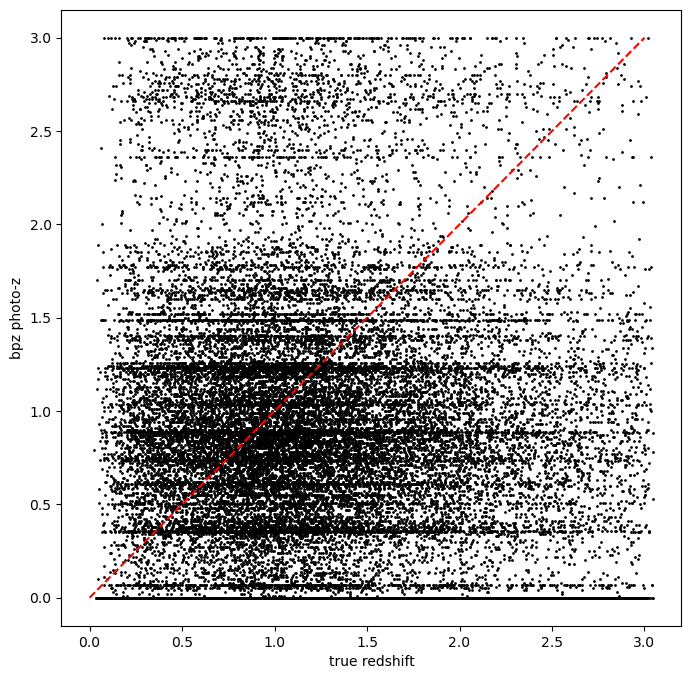

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(train_sample['z_true'],zmode,s=1,c='k',label='simple bpz mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("bpz photo-z")

// TODO conlcusão